## References:
    
https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30 <br>
https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d <br>
https://christophm.github.io/interpretable-ml-book/shap.html#advantages-15 <br>
https://afiodorov.github.io/2019/05/20/shap-values-explained/ <br>
https://medium.com/dataman-in-ai/explain-your-model-with-lime-5a1a5867b423 

In [1]:
import pandas as pd
import numpy as np

## SHAP values --> SHapley Additive exPlanations

- SHAP values - understand how they are generated
- Build SHAP values from scratch
- Use cases of SHAP values
    - What do we use them for?
    - What are they not used for?
- How are SHAP values different from other feature importance techniques?
- ELI5 package

##### State of the art in ML explainability. This algorithm was first published in 2017 by Lundberg and Lee. Used whenever we have a complex model and we want to understand what decisions the model is making.

##### Understanding the idea behind the calculation of SHAP values is crucial to make sense of a model outcome. 

## Game Theory

##### SHAP values are based on Shapley values, a concept coming from game theory. <br> Game theory is the study of mathematical models of strategic interaction among rational decision makers. It has applications in all fields of social science, as well as in logic, system science and computer science. The process of modelling strategic interaction between two or more players in a situation containing set rules and outcomes. 

Ex: Prisonoer's dilemma - two suspects for a crime - they can either testify against each other or confess they have both done the crime - the best strategy for them is to not confess but most rational people prefer to confess and testify against the other person than stay silent and take the chance the other party confesses

<img src="images/prisoners-dilemma.png" width="500" />

##### Game theory needs at least two things: a game and some players. How does this apply to machine learning explainability? Imagine that we have a predictive model, then:

- the game is reproducing the outcome of the model 
- the players are the features included in the model

##### What Shapley values do is quantifying the contribution that each player brings to the game. Equally, SHAP values are quantifying the contribution that each feature brings to the prediction made by the model. 

## Mathematical explanation

#### Imagine a model that predicts the income of a person knowing age, gender and job of the person. 
- Shapley values - the outcome of each possible combination (or coalition) of players should be considered to determine the importance of a single player
- SHAP values - in our case, this corresponds to each possible combination of features called 'power set' (f going from 0 to F, F being the number of all features available, in our example 3)

<img src="images/power-set.png" width="500" />

##### Each node is a coalition of features. Each edge represents the inclusion of a feature not present in the previous coalition. There are 8 possible combinations of features.

Now, SHAP requires to train a model for each coalition in the power set. These models have the same hyperparameters and are trained on the same data. The only thing that changes is the set of features in the model.

Let us imagine that we have trained our 8 models. We take a new observation (x0) and see what the 8 different models predict for the same observation. <br> Each node represents a model. But what do edges represent?

<img src="images/power-set-1.png" width="500" />

One node is a combination of the two upper nodes linked to it. Therefore, the difference between the predictions of two connected nodes can be imputed to the effect of that additional feature. This is called 'marginal contribution' of a feature. 

Therefore, each edge represents the marginal contribution brought by a feature to a model. 

Imagine we are in node 1, which is the model with no features. This model will simply predict the average income of all the training observations (50K). If we move to node 2, which is a model with just 1 feture (Age), the prediction for x0 is now 40K. This means that knowing the age of x0 has lowered our prediction by 10K. Thus, the marginal contribution brought by Age to the model containing only Age as a feature is -10K. 

<img src="images/marginal-contribution-formula.png" width="500" />

To obtin the overall effect of Age on the final model it is necessary to consider the marginal contribution of Age in all the model where Age is present. In our tree representation, this means to consider all the edges connecting two nodes such that
- the upper one does not contain Age, and
- the bottom one contains Age

<img src="images/power-set-2.png" width="500" />

All these marginal contributions are then aggregated through a weighted average:

<img src="images/age-contribution.png" width="500" />

where w1 + w2 + w3 + w4 = 1

How do we determine the weights of the edges (i.e. of the marginal contributions of Age in the 4 models)? 

#### 3 things to consider:

    - the sum of the weights of all the marginal contributions to 1 feature models should equal the sum of the weights of all the marginal contributions to 2 feature models and so on ... In other words, the sum of all the weights on the same row should equal the sum of all the weights on any other row
    w1 = w2 + w3 = w4
    - all the weights of marginal contributions to f feature models should equal to each other, for each f. In other words, all the edges on the same row should equal to each other. 
    w2 = w3
    - weights should add up to 1
    
Hence, the solution to the above example is: w1 = 1/3, w2 = w3 = 1/6, w4 = 1/3

The weight of an edge is the reciprocal of the total number of edges in the same row. Or, equivalently, the weight of a marginal contribution to a f-feature model is the reciprocal of the number of possible marginal contributions to all the f-feature models. 

How do we calculate them?

<img src="images/power-set-3.png" width="500" />

The way it works is for each level of the diagram (f-feature set) we multiply the number of possible models by the number of unique features per model and we take the reciprocal of this.

<img src="images/age-contribution-1.png" width="500" />

## Generalized Formula

<img src="images/generalized-formula.png" width="500" />

Applying the formula, it yields:
- SHAP of age = -11.33K
- SHAP of Gender = - 2.33K
- SHAP of Job = +46.66K

Summing them up gives +33K, which is exactly the difference between the output of the full model (83K) and the output of the dummy model with no features (50K).

##### This is a fundamental characteristic of SHAP values - summing the SHAP values of each feature of a given observation yields the difference between the prediction of the model and the null model. This is the reason for their name SHapley Additive exPlanations

## Benefits

**1. Global interpretability** - the collective SHAP values can show how much each predictor contributes, each positively or negatively, to the target variable; <br>
**2. Local interpretability** - each observation gets its own set of SHAP values <br>
**3. SHAP values can be used to explain a large variety of models including linear models, tree-based models, and neural networks, while other techniques can only be used to explain limited model types** <br>

## Example - Titanic dataset
https://app.box.com/s/zrpzj8zw35zbs8njcij40gy45gcgwsyl

In [3]:
data=pd.read_csv('data\\titanic_survival.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = data[['Sex','Age','Fare','Pclass']].copy()
y = data['Survived'].copy()

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X['Sex'])
mappping_sex = dict(zip(le.classes_, le.transform(le.classes_)))

encode_cols = ['Sex']
encoded_df = X[encode_cols]
encoded_df = encoded_df.astype('str')
encoded_df = encoded_df.apply(le.fit_transform)

# drop original cols
num_df = X.drop(encode_cols, axis = 1)
X_ = pd.concat([num_df, encoded_df], axis = 1)

X_[:2]

,Age,Fare,Pclass,Sex
0,22.0,7.2500,3,1
1,38.0,71.2833,1,0


In [6]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify = y, random_state=342)

In [8]:
import shap
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=True)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[13:26:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
# shap values represent how much this feature contributes to the output of this row's prediction
# positive shap values mean positive impact on prediction, leading the model to predict 1
# negative shap values mean negative impact, leading the model to predict 0
shap_df = pd.DataFrame(shap_values, columns=X_.columns)
shap_df

,Age,Fare,Pclass,Sex
0,0.230287,-0.204494,-0.666080,-1.292605
1,-0.359401,1.144247,2.361894,3.184605
2,-1.239497,-0.215643,-1.048865,1.374610
3,0.889444,1.455990,2.675308,2.767875
4,-0.753999,-0.001415,-0.892893,-0.699495
...,...,...,...,...
886,0.290237,0.111424,-0.636013,-1.489475
887,0.036965,0.101901,3.706076,3.455350
888,0.820689,0.369371,-1.675505,1.291918
889,0.890144,0.286097,2.725407,-0.813459


**Globsl interpretability**

In [27]:
np.mean(abs(shap_df))

Age       0.907883
Fare      1.005404
Pclass    1.201607
Sex       1.581139
dtype: float32

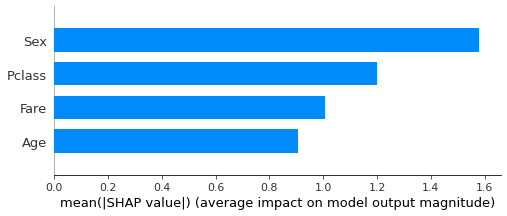

In [28]:
shap.summary_plot(shap_values, X_, plot_type='bar')

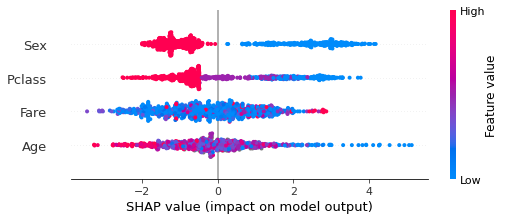

In [29]:
shap.summary_plot(shap_values, X_)

In [34]:
shap_df['Age'].max()

5.1298037

**Local interpretability**

In [60]:
explainer.expected_value

-0.6339694

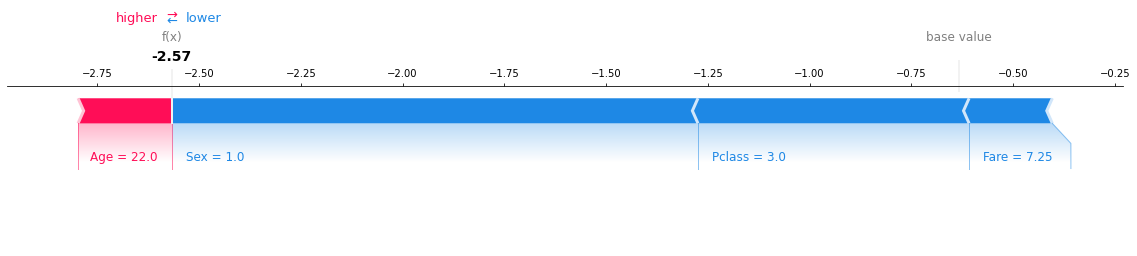

In [54]:
shap.force_plot(explainer.expected_value, shap_df.loc[0].values, X_.loc[0], matplotlib=True)

In [68]:
# from the global interpretability we see Age has a -ve relationship with survival - hence, if the Age of the obs < the mean age, the likelihood of survival will increase
X_.mean()

Age       29.699118
Fare      32.204208
Pclass     2.308642
Sex        0.647587
dtype: float64

In [61]:
# log-odds given by the waterfall plot
base_value = explainer.expected_value
pred_value = -2.57

# transform to probabilities
prob_of_1 = np.exp(pred_value)/(1+np.exp(pred_value))
print(f'Probability of a survival is {prob_of_1}\n')

# mean probability of 1 for the whole dataset
mean_prob = np.exp(base_value)/(1+np.exp(base_value))
print(f'The mean prediction for the whole dataset is {mean_prob}')

Probability of a survival is 0.07109430408428717

The mean prediction for the whole dataset is 0.34661103968162293


In [63]:
# mean prediction
y.mean(), y_train.mean(), y_test.mean()

(0.3838383838383838, 0.38342696629213485, 0.3854748603351955)

### Manually estimate shap values for 1st observation

In [10]:
shap_df.loc[0]

Age       0.230287
Fare     -0.204494
Pclass   -0.666080
Sex      -1.292605
Name: 0, dtype: float32

In [11]:
X_.loc[0]

Age       22.00
Fare       7.25
Pclass     3.00
Sex        1.00
Name: 0, dtype: float64

**Contribution of Age on the 1st sample**

In [12]:
# prediction
model.predict_proba(X_[:1])

array([[0.9286982, 0.0713018]], dtype=float32)

In [13]:
# average prediction = 0.5 when there are no features in the dataset or f=0

avg_pred = model.predict_proba(X_).mean()
avg_pred

0.5

In [14]:
# We are going to build 2^4 models where 4 is the number of features
n_models = 2**4
n_models

16

In [28]:
# when f=1 we have got 1-feature models x 4 as we have 4 features

w1 = 1/4

# contribution of a model with Age only
model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=True, eval_metric='logloss')
model_age = model.fit(X_train[['Age']], y_train)

mc_age = model_age.predict_proba(X_[['Age']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age only: {mc_age}')

Contribution of a model with Age only: 0.08488190174102783


In [29]:
# when f=2 we have got 2-feature models x 3  

w2 = w3 = w4 = 1/12 # 2*6 = 12 where 2 is the number of features in each model and 6 is the number of models

model_age_sex = model.fit(X_train[['Age','Sex']], y_train)
mc_age_sex = model_age_sex.predict_proba(X_[['Age','Sex']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Sex only: {mc_age_sex}')

model_age_fare = model.fit(X_train[['Age','Fare']], y_train)
mc_age_fare = model_age_fare.predict_proba(X_[['Age','Fare']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Fare only: {mc_age_fare}')

model_age_pclass = model.fit(X_train[['Age','Pclass']], y_train)
mc_age_pclass = model_age_pclass.predict_proba(X_[['Age','Pclass']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Pclass only: {mc_age_pclass}')

Contribution of a model with Age and Sex only: 0.4054208993911743
Contribution of a model with Age and Fare only: 0.19112354516983032
Contribution of a model with Age and Pclass only: 0.23576092720031738


In [30]:
# when f=3 we have got 3-feature models x 3

w5 = w6 = w7 = 1/12 # 3*4 = 12 where 3 is the number of features in each model and 4 is the number of models

model_age_sex_fare = model.fit(X_train[['Age','Sex','Fare']], y_train)
mc_age_sex_fare = model_age_sex_fare.predict_proba(X_[['Age','Sex','Fare']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Sex only: {mc_age_sex_fare}')

model_age_fare_pclass = model.fit(X_train[['Age','Fare','Pclass']], y_train)
mc_age_fare_pclass = model_age_fare_pclass.predict_proba(X_[['Age','Fare','Pclass']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Fare only: {mc_age_fare_pclass}')

model_age_pclass_sex = model.fit(X_train[['Age','Pclass','Sex']], y_train)
mc_age_pclass_sex = model_age_pclass_sex.predict_proba(X_[['Age','Pclass','Sex']][:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Pclass only: {mc_age_pclass_sex}')

Contribution of a model with Age and Sex only: 0.4598519802093506
Contribution of a model with Age and Fare only: 0.176971435546875
Contribution of a model with Age and Pclass only: 0.3958383798599243


In [31]:
# when f=4 we have got 4-feature models x 1

w8 = 1/4 # 1*4 = 4 where 4 is the number of features in each model and 1 is the number of models

model_all = model.fit(X_train, y_train)
mc_all = model_all.predict_proba(X_[:1])[0][0] - avg_pred
print(f'Contribution of a model with Age and Sex only: {mc_all}')

Contribution of a model with Age and Sex only: 0.42869818210601807


In [32]:
w1*mc_age + w2*mc_age_sex + w3*mc_age_fare + w4*mc_age_pclass + w5*mc_age_fare_pclass + w6*mc_age_fare_pclass + w7*mc_age_pclass_sex +w8*mc_all

0.2602355728546778

In [33]:
# manual estimated SHAP value for Age and the first instance is very clause to what we get as a shap value with the shap package
shap_df.loc[0]

Age       0.230287
Fare     -0.204494
Pclass   -0.666080
Sex      -1.292605
Name: 0, dtype: float32

In [21]:
# sum of weights has to be 1
w1+w2+w3+w4+w5+w6+w7+w8

1.0

## Pros vs Cons

**Pros**

- Since SHAP computes shapley values, all the advantages of Shapley values apply:
    - SHAP has a solid theoretical foundation in game theory
    - the prediction is fairly distributed among the feature values
    - we get contrastive explanations that compare the prediction with the average prediction
    
- SHAP connects LIME and Shapley values
    - useful to understand both methods
    
- SHAP has a fast implementation for tree-based models
    - key to the popularity of SHAP because the biggest barrier for adoption of Shapley values is the slow computation
    
- the fast computation makes it possible to compute the many Shapley values needed for the global model interpretations
    - the global interpretation methods include feature importance, interactions, clustering, summary plots, etc
    - with SHAP, global interpretations are consistent with the local explanations, since the Shapley values are the atomic unit of the global interpretations
    - if we use LIME for local explanations and partial dependence plots + permutation feature importance for global explanations, we lack a common foundation

**Cons**

- Kernel SHAP is slow 
    - this makes kernel SHAP impractical to use when you want to compute Shapley values for many instances
    - all global SHAP methods such as SHAP feature importance require computing Shapley values for a lot of instances
    
- Kernel SHAP ignores feature dependence
    - Most other permutation based interpretation methods have this problem. By replacing feature values with values from random instances, it is usually easier to randomly sample from the marginal distribution. However, if features are dependent, e.g. correlated, this leads to putting too much weight on unlikely data points. TreeSHAP solves this problem by explicitly modeling the conditional expected prediction
    
- TreeSHAP can produce unintuitive feature attributions
    - While TreeSHAP solves the problem of extrapolating to unlikely data points, it does so by changing the value function and therefore slightly changes the game. TreeSHAP changes the value function by relying on the conditional expected prediction. With the change in the value function, features that have no influence on the prediction can get a TreeSHAP value different from zero

- The disadvantages of Shapley values also apply to SHAP: Shapley values can be misinterpreted and access to data is needed to compute them for new data (except for TreeSHAP)

## ELI5

- a python lib that allows to visualize and debug various ML models using unified API
- it has built-in support for several ML frameworks and provides a way to explain white-box models (linear reg, decision trees)
    - it supports both global and local interpretability
    and black-box models (kers, xgboost, lightGBM)
     - supports only global interpretability
- the weights provided tell us how much of an impact a feature has on the predictions on average, the sign tells us in which direction

### Global interpretability

- Permutation models are used to get global interpretability
- as output it gives values similar to feature importance that you get with algorithms by default, this shows relative importance among features
- Concept
    - for each feature
        - shuffle values in the provided dataset
        - generate predictions using the model on the modified dataset
        - compute the decrease in accuracy vs before shuffling
    - compare the impact on accuracy of shuffling each feature individually
    - a feature is important if shuffling its values increases the model error because the model relied on the feature for the rpediction
    - unimportant if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction

### LIME - Local Interpretable Model-Agnostic Explanations

- For local model interpretation, ELI5 use LIME
- Local fidelity - features that are globally important may not be important in the local context, and vice versa
    - it could be the case that only a handful of variables directly relate to a local prediction, even if a model has hundreds of variables globally
- That’s why they named this technique Local Interpretable Model-Agnostic Explanations (LIME) — It should be locally interpretable and able to explain any models

- LIME like SHAP doesn't provide causality

**How is LIME different from SHAP**
- SHAP is built on the Shapley value, which is the average of the marginal contributions across all permutations 
- the Shapley values consider all possible permutations, thus SHAP is a united approach that provides global and local consistency and interpretability
- however, its cost is time - it has to compute all permutations in order to give the results
- In contrast, LIME builds sparse linear models around an individual prediction in its local vicinity
- the advantage of LIME is speed 
- the SHAP python module doesn't work with all algorithms

**How does LIME work**

<img src="images/lime.png" width="500" />

- the original complex model is represented by the blue/pink background - not linear obviously
- the red cross is the individual prediction to be explained
- LIME does the following
    - generates other samples then gets their predictions using the original model
    - weighting these new samples by the proximity to the instance being explained 
    - then it builds linear regression for these newly created samples including the red cross
    - the dashed line is the learned explanation that is locally (not globally) faithful